In [ ]:
# IV Skew Trading Strategy
'''
**Author:** Vishruth Anand  
**Date:** 2025-04-23  

**Objective:**  
Investigate whether implied volatility **skew percentiles** and **term-structure slope** (VIX / VIX3M) can forecast SPY’s 1-month forward returns. Compare a range of rule-based and logistic regression-based strategies under a volatility-targeted framework.

---

### 📌 Final Notebook Structure

1. **Setup & Data Ingestion**  
   Load SKEW, VIX, and VIX3M data from local CSVs and preview them.

2. **Feature Engineering & Forward Returns**  
   Calculate skew percentile, IV slope, and SPY forward returns.

3. **Naïve Skew-Only Strategy**  
   Simple long/short strategy based on skew percentile extremes.

4. **Continuous “Z-Score” Exposure Strategy**  
   Multiplicative signal using z-scored skew and slope + grid search.

5. **Logistic Regression Signal**  
   Binary classification model trained on `skew_pct` and `slope`.

6. **Out-of-Sample Diagnostics**  
   ROC curve, confusion matrix, and performance breakdown.

---

*Note: All strategies use volatility-targeted returns (target vol = 10% annualized).*
'''

'\n**Author:** Vishruth Anand\n**Date:** 2025-04-23  \n**Goal:** Explore whether VIX term‐structure slope and SKEW can predict subsequent SPY returns.\n### Outline\n1. Environment setup  \n2. Data ingestion & preview  \n3. Feature engineering  \n4. Baseline strategy backtest  \n5. Rule-based regime strategies  \n6. Machine-learning strategy (Logistic regression)  \n7. Out-of-sample diagnostics  \n8. Sensitivity analysis  \n9. Conclusions\n'

In [2]:
# === 1. Imports and setup ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pathlib import Path

# Set default figure size for plots
plt.rcParams['figure.figsize'] = (8, 4)

# Define data path to local CSVs
DATA_DIR = Path.home() / "Desktop" / "iv-skew-trading-strategy" / "notebooks" / "data" / "vol"



In [3]:
# === 2. Load historical volatility data ===
# Load daily CSVs and parse the "DATE" column
skew  = pd.read_csv(DATA_DIR / "SKEW_History.csv",  parse_dates=["DATE"])
vix   = pd.read_csv(DATA_DIR / "VIX_History.csv",   parse_dates=["DATE"])
vix3m = pd.read_csv(DATA_DIR / "VIX3M_History.csv", parse_dates=["DATE"])

# Set "DATE" as index and sort by date
for df in (skew, vix, vix3m):
    df.set_index("DATE", inplace=True)
    df.sort_index(inplace=True)

# Keep only the columns we care about
skew  = skew["SKEW"].rename("SKEW")          # daily SKEW index
vix   = vix["CLOSE"].rename("VIX")           # daily VIX close
vix3m = vix3m["CLOSE"].rename("VIX3M")       # daily VIX3M close

# Preview data
print(f"Rows — SKEW: {len(skew)}, | VIX: {len(vix)}, | VIX3M: {len(vix3m)}")
print("Head check:\n", pd.concat([skew.head(3), vix.head(3), vix3m.head(3)], axis=1))


Rows — SKEW: 8875, | VIX: 8911, | VIX3M: 3922
Head check:
               SKEW    VIX  VIX3M
DATE                            
1990-01-02  126.09  17.24    NaN
1990-01-03  123.34  18.19    NaN
1990-01-04  122.62  19.22    NaN
2009-09-18     NaN    NaN  26.54
2009-09-21     NaN    NaN  26.23
2009-09-22     NaN    NaN  25.69


In [4]:
# === Cell 3: Feature Engineering & Forward Returns ===
import yfinance as yf

# 3.1 Combine & forward‐fill
daily = pd.concat([skew, vix, vix3m], axis=1).ffill().dropna()

# 3.2 IV term‐structure slope & 1‐year rolling skew percentile
daily["slope"] = daily["VIX"] / daily["VIX3M"]
daily["skew_pct"] = (
    daily["SKEW"]
      .rolling(252, min_periods=200)
      .apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])
)

# 3.3 End‐of‐month snapshot
monthly = daily.resample("M").last().dropna()

# 3.4 Fetch SPY monthly closes & compute forward 1‐month returns
spy = (
    yf.download("SPY",
                start=monthly.index.min(),
                end=monthly.index.max() + pd.offsets.MonthEnd(1),
                progress=False)["Close"]
      .resample("M").last()
)
monthly["fwd_ret"] = spy.pct_change().shift(-1).reindex(monthly.index)
monthly.dropna(subset=["fwd_ret"], inplace=True)

# quick check
print(monthly.head())
print(monthly.columns.tolist())


# Define the vol_targeted_pnl function
def vol_targeted_pnl(positions, returns, target_vol=0.10, lookback=12):
    """
    Apply volatility targeting to a strategy's returns
    
    Parameters:
    -----------
    positions : pd.Series
        Raw position signals (can be -1, 0, 1 or continuous values)
    returns : pd.Series
        Asset returns corresponding to the positions
    target_vol : float, default 0.10
        Annualized volatility target (e.g., 0.10 = 10%)
    lookback : int, default 12
        Number of periods to use for volatility estimation
        
    Returns:
    --------
    pd.Series : Volatility-targeted strategy returns
    """
    # Calculate rolling volatility of returns
    vol = returns.rolling(lookback).std() * np.sqrt(12)  # Annualized
    
    # Calculate position scaling factor to achieve target vol
    # Avoid division by zero by adding a small epsilon
    scaler = target_vol / (vol + 1e-8)
    
    # Apply scaling to positions
    scaled_pos = positions * scaler
    
    # Calculate strategy returns
    return scaled_pos * returns


YF.download() has changed argument auto_adjust default to True
              SKEW    VIX  VIX3M     slope  skew_pct   fwd_ret
DATE                                                          
2010-08-31  115.02  26.05  29.04  0.897039  0.025000  0.089555
2010-09-30  120.48  23.70  26.40  0.897727  0.472222  0.038202
2010-10-31  116.04  21.20  22.95  0.923747  0.059524  0.000000
2010-11-30  116.71  23.54  25.19  0.934498  0.087302  0.066852
2010-12-31  120.74  17.75  20.90  0.849282  0.492063  0.023300
['SKEW', 'VIX', 'VIX3M', 'slope', 'skew_pct', 'fwd_ret']


In [5]:
# === Cell 4: Naïve Skew-Only Baseline ===
# Long (1) when skew in bottom 20%, short (−1) when in top 20%

# 1. Copy only the columns we need
baseline = monthly[['skew_pct', 'fwd_ret']].copy()

# 2. Define discrete positions
baseline['position'] = np.where(
    baseline['skew_pct'] <  0.20,  1,    # long when skew very low
    np.where(
        baseline['skew_pct'] > 0.80, -1,  # short when skew very high
                 0                        # otherwise flat
    )
)

# 3. Compute strategy returns
baseline['strat_ret'] = baseline['position'] * baseline['fwd_ret']

# 4. Performance summary
ann_factor = np.sqrt(12)
sharpe     = baseline['strat_ret'].mean() / baseline['strat_ret'].std() * ann_factor
cagr       = (1 + baseline['strat_ret']).prod()**(12/len(baseline)) - 1
hit_rate   = (baseline['strat_ret'] > 0).mean()

print(f"Baseline (Naïve Skew-Only)")
print(f"Obs    : {len(baseline)}")
print(f"CAGR   : {cagr:.2%}")
print(f"Sharpe : {sharpe:.2f}")
print(f"Hit    : {hit_rate:.1%}")


Baseline (Naïve Skew-Only)
Obs    : 176
CAGR   : 0.76%
Sharpe : 0.12
Hit    : 21.6%


In [7]:
# === Cell 5: Continuous “z‐Score” Exposure Strategy (cleaned) ===
"""
1) Build a continuous signal by z‐scoring skew_pct and slope.
2) Flip the sign so low skew & steep slope = long.
3) Clamp to [−1, 1] and zero out a neutral band.
4) Vol‐target P&L and compute Sharpe/CAGR/Hit.
"""

def run_continuous(monthly, lo, hi, slope_cut):
    # normalize factors
    z_skew  = (monthly["skew_pct"] - 0.5) * 2
    z_slope = (monthly["slope"] - slope_cut) / slope_cut
    raw_sig = - z_skew * z_slope
    
    # clamp & neutral band
    pos = raw_sig.clip(-1, 1)
    neutral = monthly["skew_pct"].between(lo, hi)
    pos.loc[neutral] = 0
    
    # vol‐target P&L
    pnl = vol_targeted_pnl(pos, monthly["fwd_ret"])
    
    # performance metrics
    ann = np.sqrt(12)
    sharpe = pnl.mean() / pnl.std(ddof=0) * ann
    cagr   = (1 + pnl).prod()**(12/len(pnl)) - 1
    hit    = (pnl > 0).mean()
    
    return sharpe, cagr, hit, pnl.cumprod()

# grid search
best = {"sharpe": -np.inf}
for lo in (0.05, 0.10, 0.15):
    for hi in (0.85, 0.90, 0.95):
        for slope_cut in (0.90, 0.92, 0.94, 0.96):
            s, c, h, eq = run_continuous(monthly, lo, hi, slope_cut)
            if s > best["sharpe"]:
                best.update(
                    lo=lo, hi=hi, slope_cut=slope_cut,
                    sharpe=s, cagr=c, hit=h, equity=eq
                )

# report & plot
print(f"Continuous Strategy → Sharpe {best['sharpe']:.2f}, "
      f"CAGR {best['cagr']:.1%}, Hit {best['hit']:.1%} "
      f"@ lo={best['lo']}, hi={best['hi']}, slope_cut={best['slope_cut']}")



Continuous Strategy → Sharpe 0.77, CAGR 0.3%, Hit 18.8% @ lo=0.05, hi=0.9, slope_cut=0.94


LogReg accuracy (in-sample): 0.704
First 5 signals:
 DATE
2010-08-31    1
2010-09-30    1
2010-10-31    1
2010-11-30    1
2010-12-31    1
Freq: M, Name: pred_sig, dtype: int64
First 5 pos values:
 DATE
2010-08-31    1
2010-09-30    1
2010-10-31    1
2010-11-30    1
2010-12-31    1
Freq: M, Name: pred_sig, dtype: int64
Any nonzero positions? True
🔍 ret.describe():
 count    165.000000
mean       0.009608
std        0.030552
min       -0.063241
25%       -0.010479
50%        0.012474
75%        0.028460
max        0.101160
dtype: float64
Sample Sharpe (LR): 1.093


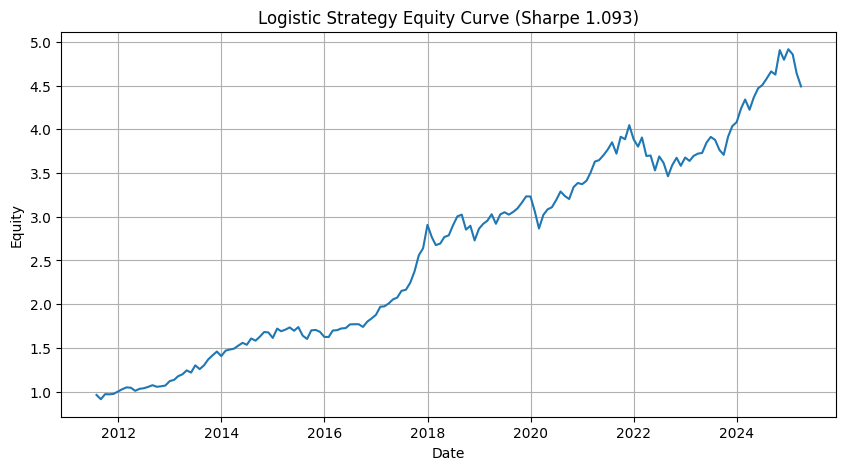

CAGR: 11.54%
Hit Rate: 68.5%


In [ ]:
# === Cell 6.  logistic classifier on skew_pct + slope ===
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# — rebuild monthly + fwd_ret so this cell always works —
daily = pd.concat([vix, vix3m, skew], axis=1).dropna()
daily["slope"]    = daily["VIX"] / daily["VIX3M"]
daily["skew_pct"] = (daily["SKEW"]
                      .rolling(252, min_periods=200)
                      .apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])
                    )
monthly = daily.resample("M").last().dropna()

spy = yf.download("SPY",
                  start=monthly.index.min(),
                  end=monthly.index.max()+pd.offsets.MonthEnd(1),
                  progress=False)["Close"]
spy_m = spy.resample("M").last()
monthly["fwd_ret"] = spy_m.pct_change().shift(-1).reindex(monthly.index)
monthly.dropna(subset=["fwd_ret"], inplace=True)


# 4a) Prepare features X and binary label y (1 = next month up, 0 = next month down)
X = monthly[["skew_pct", "slope"]]
y = (monthly["fwd_ret"] > 0).astype(int)

# 4b) Split in-sample / out-of-sample (e.g. train on pre-2021 data)
train_mask = monthly.index < "2021-01-01"
X_train, y_train = X.loc[train_mask], y.loc[train_mask]

# 4c) Train the model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# 4d) Generate predictions (probabilities) and turn into a signal ∈ {+1, –1}
monthly["pred_prob"] = lr.predict_proba(X)[:,1]       # P(y=1)
monthly["pred_sig"]  = np.where(monthly["pred_prob"] > 0.5, 1, -1)

# Quick sanity-check
print("LogReg accuracy (in-sample):",
      lr.score(X_train, y_train).round(3))
print("First 5 signals:\n", monthly["pred_sig"].head())
# 1️⃣ Test the logistic signal
pos = monthly["pred_sig"]
print("First 5 pos values:\n", pos.head())
print("Any nonzero positions?", (pos != 0).any())
# 2️⃣ Apply your vol-targeting to the LR signal
ret = vol_targeted_pnl(pos, monthly["fwd_ret"]).dropna()

# Quick diagnostics
print("🔍 ret.describe():\n", ret.describe())
ann_factor = np.sqrt(12)
sample_sharpe = ret.mean() / ret.std(ddof=0) * ann_factor
print(f"Sample Sharpe (LR): {sample_sharpe:.3f}")

import matplotlib.pyplot as plt

# 3️⃣ Equity curve for the logistic‐regression strategy
equity = (1 + ret).cumprod()
plt.figure(figsize=(10, 5))
plt.plot(equity)
plt.title(f"Logistic Strategy Equity Curve (Sharpe {sample_sharpe:.3f})")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.grid(True)
plt.show()

# Compute and display CAGR and hit rate
cagr = (1 + ret).prod()**(12/len(ret)) - 1
hit = (ret > 0).mean()
print(f"CAGR: {cagr:.2%}")
print(f"Hit Rate: {hit:.1%}")



In-Sample    | Obs: 90 | Sharpe:1.34 | CAGR:15.1% | Hit:72.2%
Out-of-Sample | Obs: 75 | Sharpe:0.78 | CAGR:7.5% | Hit:64.0%

OOS Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

    accuracy                           0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75

OOS Confusion Matrix:
 [[ 0 27]
 [ 0 48]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

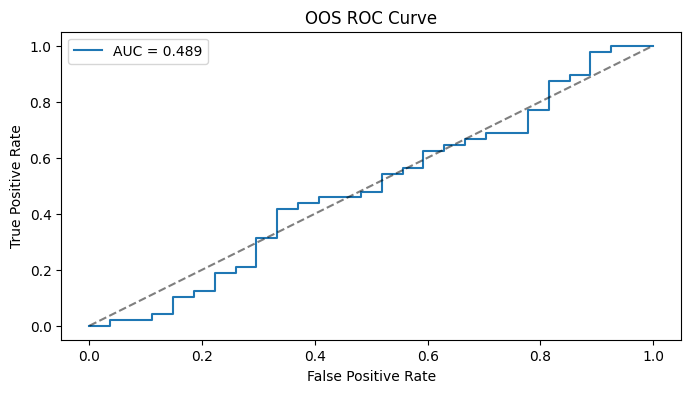

In [ ]:
# === Cell 7: Out-of-Sample Diagnostics & ROC for Logistic Strategy ===
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

# 1) Rebuild signals on full sample
X = monthly[["skew_pct", "slope"]]
y = (monthly["fwd_ret"] > 0).astype(int) 
pred_proba = lr.predict_proba(X)[:,1]
monthly["sig_lr"] = np.where(pred_proba > 0.5, 1, 0)

# 2) Split masks on the original monthly index
split = "2018-12-31"
mask_train = monthly.index <= split
mask_test  = monthly.index >  split

# 3) Compute vol-targeted returns (keep full index)
ret_full = vol_targeted_pnl(
    positions=monthly["sig_lr"].replace({0: -1}),
    returns=monthly["fwd_ret"]
)

# 4) Now slice into train/test (no length mismatch)
ret_train = ret_full.loc[mask_train].dropna()
ret_test  = ret_full.loc[mask_test].dropna()

# 5) Print train vs test performance
def perf(r):
    ann = np.sqrt(12)
    return (
        r.mean()/r.std(ddof=0)*ann,
        (1+r).prod()**(12/len(r)) - 1,
        (r>0).mean()
    )

sh_tr, cagr_tr, hit_tr = perf(ret_train)
sh_te, cagr_te, hit_te = perf(ret_test)

print(f"In-Sample    | Obs:{len(ret_train):3d} | Sharpe:{sh_tr:.2f} | CAGR:{cagr_tr:.1%} | Hit:{hit_tr:.1%}")
print(f"Out-of-Sample | Obs:{len(ret_test):3d} | Sharpe:{sh_te:.2f} | CAGR:{cagr_te:.1%} | Hit:{hit_te:.1%}")

# 6) OOS confusion & classification report
y_pred = monthly["sig_lr"].loc[mask_test]
y_true = y.loc[mask_test]
print("\nOOS Classification Report:\n", classification_report(y_true, y_pred))
print("OOS Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# 7) OOS ROC curve
fpr, tpr, _ = roc_curve(y_true, pred_proba[mask_test])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("OOS ROC Curve")
plt.legend()
plt.show()
